# Chapter 2 - Accessing the Dataset

This notebook is split into the followin sections:

- [2.1 Understanding the Dataset](#understanding)

- [2.2 Subset the dataset](#sub)

- [2.3 Interact with the dataset](#interact) 

- [2.4 Interact with a table to query column descriptions](#columns)

#### Jupyter Notebook Help

The Jupyter Notebook team has lots of great [documentation](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html) regarding the use of notebook. Check it out if you are interested in learning more.

#### Python Pandas Resources

Pandas is a python package that is regulary used throughout this workshop. You may have some extra questions or need some practice with this package. Check out the [tutorials](https://pandas.pydata.org/docs/getting_started/tutorials.html) and the [documentation](https://pandas.pydata.org/docs/user_guide/index.html#user-guide) for more information.

#### Assets

In [13]:
import warnings
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv
from upath import UPath as Path
from aicsimageio import AICSImage
from ome_zarr.reader import Reader
from ome_zarr.io import parse_url
import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)

## Chapter 2.1 Understanding the Dataset

### The hiPSC Single-Cell Image Dataset
Our dataset consists of 3D live-cell images of *normal human induced pluripotent stem cells (hiPSCs)*, which are a useful human cell model system. The dataset includes 25 cell lines representing fluorescently tagged major organelles, cellular structures, and compartments. Images of these cells were obtained in 3D using spinning-disk confocal microscopes and were further processed using deep learning-based segmentation.

<img src="resources/hipsc_single_cell_image_dataset_summary.png"/>

As was described in the first chapter, the dataset consists of 25 different fluorescently tagged proteins that we use to visualize some of the majore organelles. Below you'll find a table that describes the gene, protein, a description, where in the cell the protein is generally locatated, as well the structure that the protein represents.

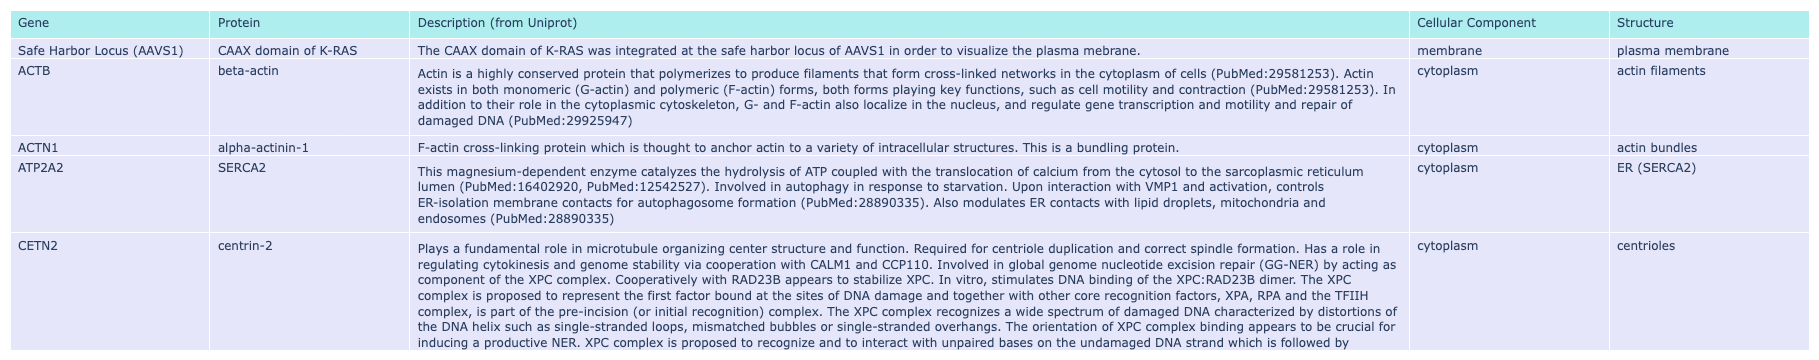

In [ ]:
import plotly.graph_objects as go
cell_line_anno = pd.read_csv("resources/cell_line_annotation.txt",delimiter="\t")

fig_tab = go.Figure(
    data=[go.Table(
        columnwidth=[80,80,400,80,80],
        header=dict(values=list(cell_line_anno.columns),
            fill_color='paleturquoise',
            align = 'left'),
        cells=dict(values=[cell_line_anno.Gene,cell_line_anno.Protein,cell_line_anno['Description (from Uniprot)'],cell_line_anno['Cellular Component'],cell_line_anno.Structure],
                   fill_color='lavender',
                   align='left'))

    ]
)
fig_tab.update_layout(
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=4
    ),
)
fig_tab.show(renderer="jupyterlab")

#### Load the manifest

In order to access the dataset we have created a manifest where each row is a cell and each column has different meta-data, metrics, and paths relating to those cells. This will be the primarily way to access and manipulate the data. We begin by first loading the manifest using the pandas read_parquet function. We then set the index of the data frame using the CellId column to ensure that the CellId is propgated throughout any of our filtering steps.

In [14]:
df = pd.read_parquet('./resources/hackathon_manifest_092022.parquet')
df.set_index(df['CellId'].astype(int), inplace=True)
df.shape

(214037, 78)

The manifest contains **214037** rows which represent the cells and **78** columns of metrics, metadata, and image paths which will be described later!

### From FOVs to single-cell images
The original hiPSC Single-Cell Image dataset consists of **215,081** single-cell images which were extracted from **18,100** fields of view (FOVs) of our cell colonies. Segmentations were computed at the FOV level using the Allen Cell and Structure Segmenter (Chen et al., 2018), with code and trained models available at https://github.com/AllenCell/segmenter_model_zoo. Single cells were extracted from the FOVs using the cell segmentation results. All images were rescaled to isotropic voxel sizes by interpolating along the z dimension to upscale the voxel size from 0.108333 $\mu$m x 0.108333 $\mu$m x 0.29 $\mu$m  to 0.108333 $\mu$m x 0.108333 $\mu$m x 0.108333 $\mu$m. ROIs were determined by extending the 3D bounding box of the cell by 40 pixels in x and y, and 10 pixels in z. 

The single-cell images were further processed via a filtering in which outliers were identified based on cell and nuclear metrics e.g. cell surface area and nuclear volume. For our purposes we have removed any cells that were originally identified as an  `outlier` from our processing. The version of the dataset we're working with has outliers removed, resulting in **214,037** single-cell images. The code for this processing is available at https://github.com/AllenCell/cvapipe_analysis/tree/master/cvapipe_analysis/steps/preprocessing. You'll learn more about the cell processing steps in the next chapter.


### Overview - FOVs per gene

The cell images came from over 18K FOVs and are scattered across the 25 different cell lines. We can parse the manifest and utilize it to understand how many FOV's were captured per gene.  The below code takes the manifest `df` and groups the data by the `gene` column. This allows us to perform any operation on our grouped data, and in this instance we'll access the`FOVId` column and count the number of FOVId's that were captured per gene.

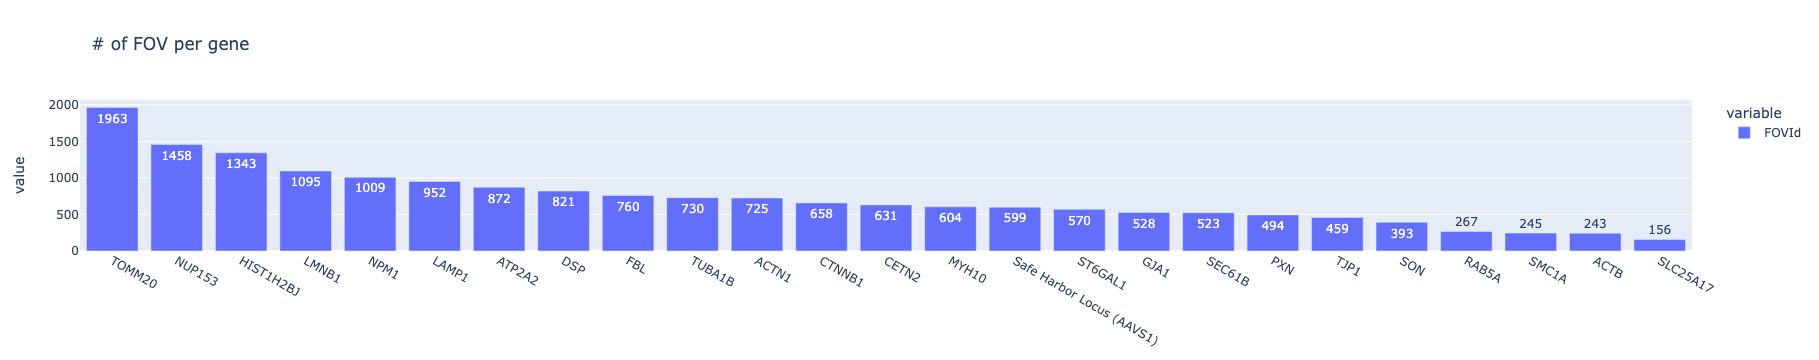

In [16]:
fig_fovstruc = px.bar(df.groupby(['gene']).FOVId.nunique(),text_auto=True,title="# of FOV per gene")
fig_fovstruc.update_layout(xaxis=dict(categoryorder="total descending"),overwrite=True)
fig_fovstruc.show()

The number of FOVs isn't evenly distributed between the cell lines. In addition, the number of cells in an FOV varies based on position of the colony as well as the confluence of the wells. We can visualize the distribution of cells per FOV using a violin plot. We can parse the dataframe to calculate the number of cells per FOVId grouped by gene and then merge these counts into a new data frame for easy access later. Then we can visualize using a violin plot.

The groupby function is very handy for performing operations across different grouped columns. For example we can easily replace the above code with a different column - say `cell component` to understand how many FOVs were captured for structures residing in particular cellular localizations.

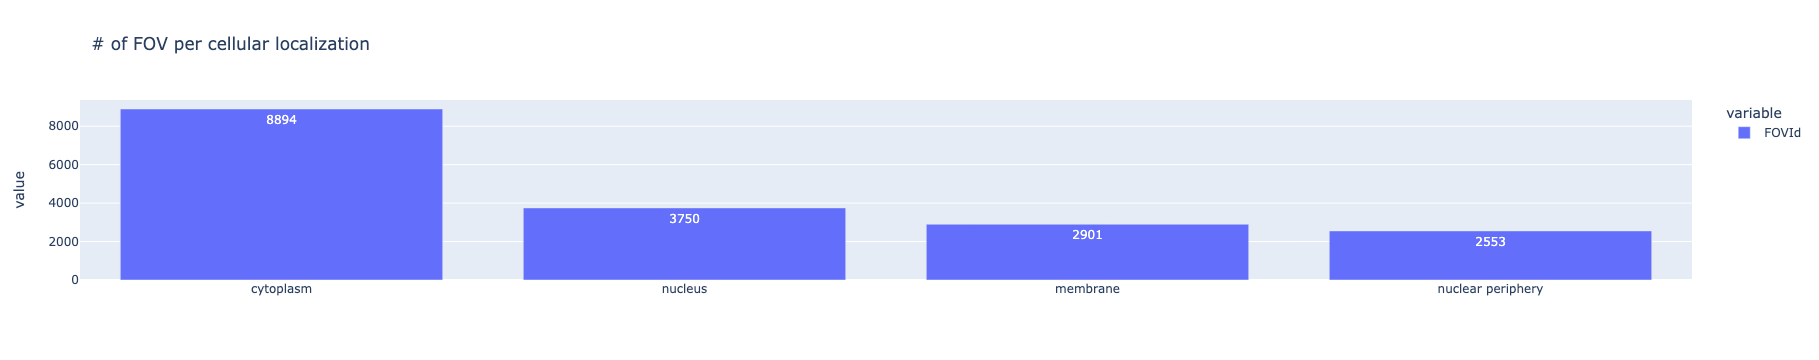

In [20]:
fig_fovstruc = px.bar(df.groupby(['Cellular Component']).FOVId.nunique(),text_auto=True,title="# of FOV per cellular localization")
fig_fovstruc.update_layout(xaxis=dict(categoryorder="total descending"),overwrite=True)
fig_fovstruc.show()

### Overview - Cells per FOV

Each FOV contains a different numbers of cells that is determined by a variety of factors including confluency (how dense the cells are on the plate) as well as colony position (some FOVs can be centered on the colony while others are at the edges of our colonies). We can quickly look at the number of cells per FOV by using our groupby function. However in this case, we'll do some more advanced filtering in order to retain an FOVId which we will use in the next step.

The code below groups the manifest again by `gene` and then again counts the number cells contained in each`FOVId` and creates a new dataframe `cell_count_per_FOV` this ultimately is used to create a dataframe that has FOVID and cell count as the columns all grouped by the `gene`. We can then plot this as a combination violin and box plot to understand the distribution of cells per FOV.

In [21]:
cells_per_fov = (
    df.groupby('gene').FOVId 
    .value_counts()
    .to_frame(name="cell_count_per_FOV")
    .reset_index()
    .set_index('FOVId')
    .merge(
        df[['FOVId']]
        .drop_duplicates(subset=['FOVId'])
        .set_index('FOVId'),
        left_index=True,
        right_index=True
    )
    .reset_index()
)

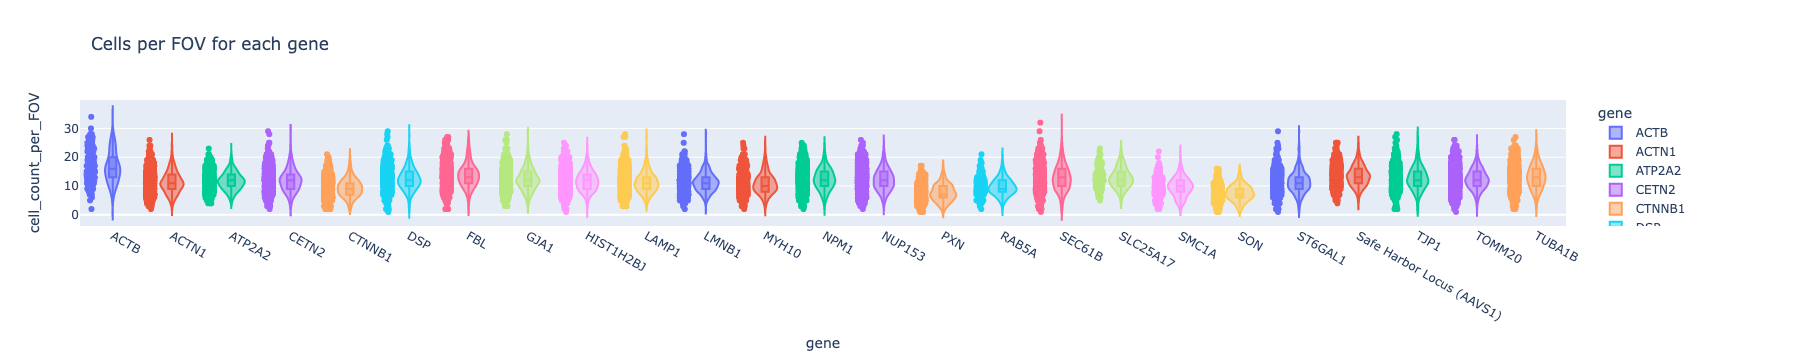

In [22]:
fig_cells_fov = px.violin(
    cells_per_fov,
    x=cells_per_fov.gene,
    y=cells_per_fov.cell_count_per_FOV,
    box=True,
    points='all',
    color=cells_per_fov.gene,
    hover_data=cells_per_fov,
    title="Cells per FOV for each gene"
)
fig_cells_fov.show()

Visualizing the data we can see that overall the distribution of the number of cells is consistent through the different cell lines. We can see that it FOV's generally contain between 2 and 20+ cells with a median around 14.  Though the FOV data is not included for the purposes of this task we can still visualize the FOVs as they are publically available data.  First we'll create a simple function that uses the FOVId to identify a Cell ID which we can use in our browser based cell viewer. You'll learn more ways to visualize the cells in the next chapters. But for now we can take a quick peek with the link below.

In [23]:
def generate_url(FOV_of_interest):
    cell_id = df[df['FOVId']==FOV_of_interest].CellId.tolist()[0]
    print(f"Click this link https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id={int(cell_id)} and select the Full Field at the top of the screen")

We can hover the data from the violin plot above and select the highest point within the **ACTB** scatter plot and see that the **FOVID is 5785**. We'll use this to look at an FOV with 34 cells! 

In [24]:
FOV_of_interest = 5785 # CHANGE ME -  Enter FOV of interest in this case 5785 which comes from the max number of cells of of ACTB
generate_url(FOV_of_interest)

Click this link https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id=439315 and select the Full Field at the top of the screen


The above code is just one of the many ways you'll learn how to visualize the cells that is included in **Chapter 3**.

### Overview - Cells per gene

The dataset consists of over 200K cells and based on the number distribution of FOVs we can assume that they are not evenly spraed across the 25 cell lines. We can visualize the number of cells per gene by further parsing the data frame.

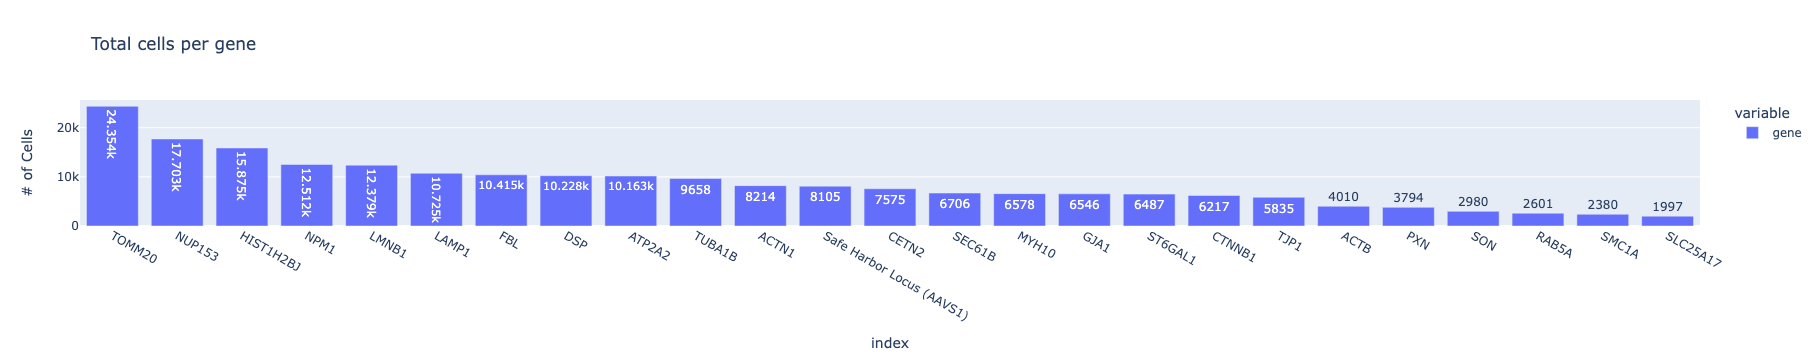

In [25]:
fig_total = px.bar(df.gene.value_counts(),text_auto=True,title="Total cells per gene",labels=dict(value="# of Cells"))
fig_total.show()

## Chapter 2.2 Sub-Datasets

### Dataset Categories

The dataset is quite complex representing multiple cell lines that span different cellular structures as well cellular localizations. In addition we have **78** metadata columns that are associated with each cell! In order to help with parsing we have broken down the dataset columns into 4 Categories [`cell metadata`, `field-of-view metadata`,`cell metric`,`cell images`] with a brief description of them below:

**cell metadata**: These 11 columns contain metadata pertaing to the cells, for example the cell cycle stage (cell_stage) and the tagged structure name (Structure).

**field-of-view metadata**: These 15 columns that annotate the field-of-view including: instrument used (instrumentId) plate confluency (meta_plate_confluency) and more.

**cell metric**: These 35 columns are metrics that pertain to the cell such as angle of rotation and bounding box information, structure volume, and nuclear volume.

**cell images**: These 12 columns give the paths to various types of images including max projections and center slices.

<img src="resources/Chapter2_columns.png"/>


For ease of use we've decided to use a pivot table in order to filter the columns. We'll give some examples on how this will work below. First we need to read in the pivot table.

In [26]:
col_df = pd.read_csv("resources/hackathon_column_descriptions.csv",delimiter=",")
col_df.columns = ["column name","description","category"]
col_df.head(3)

,column name,description,category
0,angle,angle of rotation to get cell on the long axis,cell metric
1,bbox_max_x,Bounding Box top X coordinate,cell metric
2,bbox_max_y,Bounding Box top Y coordinate,cell metric


### Creating Sub-Datasets

With the pivot table we can quickly and easily parse the data set select out specific categories of data. For example, if we wanted to see all the columns that pertained to the *cell metatdata* we would use the code below. 
We take our dataframe `df` and filter for only the `column name` that are associated with `cell metadata` in our pivot table `col_df`. 

In [32]:
df_cell_metadata = df.filter(items=(col_df[col_df.category=="cell metadata"]['column name']))
df_cell_metadata.head(3)

,cell_stage,CellId,Cellular Component,Description (from Uniprot),Draft mitotic state resolved,edge_flag,gene,Structure,this_cell_index,this_cell_nbr_complete,Protein
CellId,,,,,,,,,,,
230741,M4M5,230741,cytoplasm,Central component of the receptor complex resp...,None,0,TOMM20,mitochondria,1,1,Tom20
230745,M0,230745,cytoplasm,Central component of the receptor complex resp...,None,0,TOMM20,mitochondria,5,1,Tom20
230746,M0,230746,cytoplasm,Central component of the receptor complex resp...,M0,0,TOMM20,mitochondria,6,0,Tom20


The above code can be changed to any of the four categories [`cell metadata`, `field-of-view metadata`,`cell metric`,`cell images`] to quickly get the corresponding information. In section 2.4 we have verbose descriptions of our columns which will allow you to get a better understanding of what each of these values represents.

#### Compute mean of cellular rotation per gene

We've already previously learned of ways to split the data based on the broad column categories such as cell_metadata. But we can also quickly operate on specific columns in the usual pandas syntax. For example the cells have all been rotated to their long axis. A question we may have is if all the cell lines had a simliar mean rotational angle. To address this we simply need two columns,  1)**angle**  and 2) **gene** from the manifest. Below is code to access these columns.

First we create a new dataframe with only the columns we are interested in. Then we take the absolute value of the angle as we are interested in whether is was rotated clockwise or counter-clockwise and finally we groupby gene and calculate the mean.

In [37]:
# Same as 
df_angle = df[['angle','gene']].copy()
df_angle['angle'] = df_angle[('angle')].abs()
df_angle.groupby('gene').mean()

,angle
gene,
ACTB,43.942879
ACTN1,43.618125
ATP2A2,44.097111
CETN2,44.421069
CTNNB1,44.345526
DSP,43.116937
FBL,43.570644
GJA1,44.815820
HIST1H2BJ,43.477949


Parsing the data this way we can see that the mean rotational angle is fairly similiar across the different cell lines.

## Chapter 2.3 Interacting with the Dataset

Throughout this hackathon you will often interact with Pandas DataFrames. For those unfamiliar with Pandas DataFrames, some helpful querying and grouping functions are explored within this sub-chapter. 

Subdatasets can be generated based upon some conditional, these conditionals follow standard boolean logic. Say for example you want to subset on very specific criteria and are interested in using only the `NUP153` cell line that were in interphase `M0` and had a nuclear height > 3 microns. That would be represented by the below code:

#### Filtering

In [38]:
# Boolean Indexing
df_filtered_boolean_indexing = df[
    (df['gene'] == "NUP153") &
    (df['cell_stage'] == "M0") &
    (df['nuclear_height'] > 3)
]

df_filtered_boolean_indexing.shape

(16817, 78)

We now have a new dataframe that contains **16817** cells all of NUP153 at interphase and having a nuclear height greater than 3 microns!

Similarly you can filter catagorical variables using list indexing. This allows us to gather data across multiple different values and in this case we are creating a new data frame with `NUP153` `PXN` and `TOMM20`.

In [16]:
# List Indexing 
value_list = [
    "NUP153",
    "PXN",
    "TOMM20",
]

df_list_index = df[df["gene"].isin(value_list)]
df_list_index.shape

(45851, 78)

#### Grouping

Being able to group data by some criteria is a useful tool for analysis. Using Pandas built in function .groupby we gather useful information on a particular slice of the data. We've already used this function quite extensively in the previous code blocks. But here we demonstrate the useful function `describe`. Say for example we quickly want to understand what the number, mean, std, min, and max of a specific metric is. Below we take a look at the `nuclear_volume

In [42]:
# Grouping
df_groupby = df.groupby(['gene'])
df_groupby.nuclear_volume.describe()

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
ACTB,4010.0,550.073328,172.187209,76.509056,438.949047,535.582462,653.016940,1494.936630
ACTN1,8214.0,549.262034,184.254973,41.302710,436.248275,539.876617,663.695749,1520.946938
ATP2A2,10163.0,444.919202,132.225361,38.021226,356.023869,433.659386,527.043102,1384.668082
CETN2,7575.0,540.922476,177.041840,40.227106,428.286448,533.457952,650.581891,1707.559260
CTNNB1,6217.0,546.300572,176.876904,51.836262,433.761098,536.598311,655.345828,1508.413474
DSP,10228.0,555.827474,166.991559,47.630469,445.461477,540.170946,660.704462,1392.924556
FBL,10415.0,544.089984,170.460219,68.143242,433.550681,529.421257,651.274168,1889.263977
GJA1,6546.0,538.954979,173.463913,58.973903,426.523970,526.549799,645.722599,1699.281172
HIST1H2BJ,15875.0,475.939712,147.809395,40.804321,380.370549,465.113829,566.709520,1446.498822


#### Missing Data

The dataset contains many columns that may be missing values, though sparse, this omittence can affect your process. In this subsection some simple ways to interact with empty cells are explored.

In [24]:
# Dropping missing values by column or whole dataset
df_dropna = df.copy()
df_dropna.dropna(subset=['shape_mode_3_major_tilt'], inplace = True)
df_dropna.shape

(175147, 78)

In [25]:
# Filling, either by single column or whole dataset 
df_fill_na = df.copy()
df_fill_na['shape_mode_3_major_tilt'] = df_fill_na['shape_mode_3_major_tilt'].fillna(0)
df_fill_na.shape

(214037, 78)

## Chapter 2.4 Column Descriptions


The dataset contains 78 columns with important metrics which you may want to incorporate during the challenge. In this section we'll create a tiny dash app that runs within the notebook in order to display an interactive table of the columns and their descriptions. **The table is searchable** lending itself to more efficient querying.

In [4]:
from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html 
JupyterDash.infer_jupyter_proxy_config()

In [5]:
col_df = pd.read_csv("resources/hackathon_column_descriptions.csv",delimiter=",")
col_df.columns = ["column name","description","second header"]

In [6]:
# Some sort of Look up method built in for looking at column definitions 
from dash import dash_table
app = JupyterDash(__name__)
server = app.server

app.layout = dash_table.DataTable(
    col_df.to_dict('records'), 
    [{"name": i, "id": i} for i in col_df.columns],
    style_data={
        'whiteSpace':'normal',
        'height': 'auto',
        'lineHeight':'15px',
        'backgroundColor': 'rgb(50,50,50)',
        'color': 'white',
    },
    style_header={
        'backgroundColor':'rgb(30,30,30)',
        'color':'white'
    },  
    style_cell={
        'textAlign':'left'
    },
    filter_action="native",
)


In [7]:
app.run_server(mode="jupyterlab",host="0.0.0.0", port=8050,) # This runs on a specified port. Either enable port forwarding on your maching. #TODO work with Gui to enable this directly from the app rather than port forwarding. 